# Laboratorio 1

In [25]:
#Instalcion de todas las librerias
import pandas as pd
import numpy as np
import sys
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt

### Carga de datos

In [26]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('train_data.csv', sep=',', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data_t=data

In [27]:
data_t

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
0,1237648722306924571,185.574486,0.701402,19.11034,17.62099,17.03464,16.82993,16.71711,756,5,466,0.864145,1,STAR,8.780529e-05,54140,0.002418,0.001363
1,1237648720167436418,203.801841,-0.853906,18.90957,17.62940,17.01465,16.62059,16.35239,756,1,588,0.816541,1,GALAXY,8.619995e-02,51955,0.008650,0.007056
2,1237648720685105352,160.034264,-0.421626,19.26340,17.67693,16.82551,16.42307,16.13864,756,2,295,0.870381,1,GALAXY,1.330486e-01,51913,0.003938,-0.002028
3,1237648703510937836,200.807373,-0.682024,18.82022,17.77765,17.38575,17.11128,16.93540,752,2,382,0.867801,1,GALAXY,8.636355e-02,51959,0.001839,0.001160
4,1237648720161275992,189.792404,-1.001480,18.91391,19.05355,19.46278,19.75660,20.09613,756,1,494,0.833824,1,STAR,-4.090000e-08,54562,0.001929,-0.000465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1237648720690741273,172.826005,-0.484303,18.81890,17.89273,17.54372,17.41363,17.31821,756,2,381,0.887803,1,STAR,1.521540e-04,54891,0.000675,0.000324
3996,1237649918427267086,11.165126,13.745240,17.46665,15.96142,15.36014,15.14572,15.04453,1035,1,38,0.844826,1,STAR,4.182837e-05,53242,-0.000440,-0.000301
3997,1237648720164684046,197.579529,-0.971573,19.45682,18.32555,17.86916,17.57512,17.41648,756,1,546,0.819151,1,GALAXY,8.160563e-02,51985,0.011348,0.005854
3998,1237648721206575779,124.877626,-0.048110,19.20158,17.31450,16.36573,15.91760,15.57736,756,3,60,0.894044,1,GALAXY,8.744828e-02,55888,-0.004486,-0.006072


## Entendimiento de los Datos

Antes de comenzar a analizar los datos, es fundamental identificar cuáles son más importantes que otros.

###  Variables Necesarias

- **ra (Ascensión recta)**
  - Indica la posición del objeto en el cielo.
- **dec (Declinación)**
  - Complementa la posición del objeto en coordenadas celestes.
- **u, g, r, z, i (Magnitudes en diferentes filtros)**
  - Permiten clasificar y caracterizar los objetos en función de su emisión de luz en distintos rangos de longitud de onda.
  - Son fundamentales para estimar redshifts fotométricos si se quiere hacer una estimación sin espectroscopía.
- **class**
  - Indica si el objeto es una estrella (**STAR**), una galaxia (**GALAXY**) o un cuásar (**QSO**).
  - Importante porque el redshift se aplica principalmente a galaxias y cuásares.
- **redshift**
  - Es el valor clave de estudio, ya que representa el corrimiento al rojo del objeto.
- **mjd (Día juliano)**
  - Puede ser útil si se estudian variaciones en observaciones a lo largo del tiempo.

###  Variables Opcionales o Menos Relevantes

- **run, camcol, field**
  - Se relacionan con la instrumentación del telescopio y pueden ser útiles para control de calidad, pero no necesariamente para el análisis del redshift.
- **score**
  - Indica la calidad de la observación. Podría ser útil para filtrar datos de baja calidad.
- **clean**
  - También puede ayudar a filtrar observaciones con problemas en la fotometría.
- **rowv y colv**
  - Indican velocidades en grados/día, que pueden ser útiles si se quiere analizar movimiento propio, pero no son necesarias para un análisis del redshift.




In [28]:
#Entendimiento del tamaño del data Set a ser manejado
print('Dimensiones de los datos: ', data_t.shape, 'El primer valor corresponde a filas y el segundo a columnas')

Dimensiones de los datos:  (4000, 18) El primer valor corresponde a filas y el segundo a columnas


In [29]:
# Visualizacion de los primeros 10 datos
display(data_t.head(10))

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
0,1237648722306924571,185.574486,0.701402,19.11034,17.62099,17.03464,16.82993,16.71711,756,5,466,0.864145,1,STAR,8.780529e-05,54140,0.002418,0.001363
1,1237648720167436418,203.801841,-0.853906,18.90957,17.62940,17.01465,16.62059,16.35239,756,1,588,0.816541,1,GALAXY,8.619995e-02,51955,0.008650,0.007056
2,1237648720685105352,160.034264,-0.421626,19.26340,17.67693,16.82551,16.42307,16.13864,756,2,295,0.870381,1,GALAXY,1.330486e-01,51913,0.003938,-0.002028
3,1237648703510937836,200.807373,-0.682024,18.82022,17.77765,17.38575,17.11128,16.93540,752,2,382,0.867801,1,GALAXY,8.636355e-02,51959,0.001839,0.001160
4,1237648720161275992,189.792404,-1.001480,18.91391,19.05355,19.46278,19.75660,20.09613,756,1,494,0.833824,1,STAR,-4.090000e-08,54562,0.001929,-0.000465
5,1237648720132178408,123.386052,-1.045499,18.52214,17.45173,17.23112,17.16427,17.13214,756,1,50,0.851417,1,STAR,1.190440e-05,53816,-0.002165,-0.000364
6,1237648720165863598,200.243728,-0.895931,18.09523,16.82764,16.18942,15.83503,15.58671,756,1,564,0.815295,0,GALAXY,4.815651e-02,51984,-0.011610,0.002361
7,1237648704054624442,216.256661,-0.220799,19.20765,18.73173,18.84302,18.98353,19.15128,752,3,486,0.804086,1,STAR,-2.234210e-04,51613,-0.002153,-0.001026
8,1237648722308890870,190.050847,0.695672,17.82951,15.90091,15.02515,14.61881,14.30353,756,5,496,0.822898,1,GALAXY,4.634102e-02,51941,-0.000474,-0.001548
9,1237648720163963081,195.951990,-0.966005,17.76132,16.51327,15.89811,15.53069,15.31236,756,1,535,0.811336,1,GALAXY,8.944633e-02,51986,0.000894,0.001024


In [30]:
# Imprimimos los diferentes tipos de las columnas
data_t.dtypes

objid         int64
ra          float64
dec         float64
u           float64
g           float64
r           float64
i           float64
z           float64
run           int64
camcol        int64
field         int64
score       float64
clean         int64
class        object
redshift    float64
mjd           int64
rowv        float64
colv        float64
dtype: object

In [31]:
# Imprimir las columnas numericas
columnasNumericas= data_t.select_dtypes(include=['int','float']).columns
print(columnasNumericas)

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field',
       'score', 'clean', 'redshift', 'mjd', 'rowv', 'colv'],
      dtype='object')


In [32]:
data_t.describe( include='all')

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
count,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000,4000.000000,4000.000000,4000.000000,4000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GALAXY,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1857,NaN,NaN,NaN,NaN
mean,1.237649e+18,185.523295,0.248959,18.609049,17.363397,16.839856,16.597712,16.439392,743.829000,3.37625,419.602000,0.851765,0.895500,NaN,0.134015,52957.124750,0.000218,-0.000090
std,4.244222e+11,41.689446,2.001075,0.839431,0.950964,1.055343,1.141252,1.190502,98.865936,1.69909,167.162063,0.071311,0.305946,NaN,0.379742,1601.148131,0.008794,0.007457
min,1.237646e+18,10.469743,-1.252763,13.551780,12.974870,12.362850,12.010790,11.799530,211.000000,1.00000,19.000000,0.301912,0.000000,NaN,-0.003322,51608.000000,-0.264516,-0.168807
25%,1.237649e+18,162.474666,-0.631824,18.170375,16.796110,16.190785,15.870782,15.628205,752.000000,2.00000,311.000000,0.836866,1.000000,NaN,0.000106,51821.000000,-0.001212,-0.001609
50%,1.237649e+18,195.815451,0.053336,18.843745,17.472525,16.850835,16.571195,16.402665,756.000000,3.00000,434.000000,0.860675,1.000000,NaN,0.032038,51986.000000,0.000322,0.000125
75%,1.237649e+18,214.348425,0.593396,19.261563,17.997818,17.506640,17.258833,17.147037,756.000000,5.00000,527.000000,0.879834,1.000000,NaN,0.086479,54468.000000,0.001698,0.001672


### Ahora vamos a empezar a revisar los datos que se encuentran mal de cada columna en base a sus datos para ver si se pueden corregir o deben de ser eliminados

In [33]:
#Para empezar revisamos si hay valores nulos en el dataset, pero no se encuentran datos nulos
data_t.isnull().sum()

objid       0
ra          0
dec         0
u           0
g           0
r           0
i           0
z           0
run         0
camcol      0
field       0
score       0
clean       0
class       0
redshift    0
mjd         0
rowv        0
colv        0
dtype: int64

### Revisando la Columna 'ra' la cual describe Ubicación del objeto en su componente de ascensión recta de coordenada celeste.

In [34]:
data['ra'].describe()

count    4000.000000
mean      185.523295
std        41.689446
min        10.469743
25%       162.474666
50%       195.815451
75%       214.348425
max       249.758313
Name: ra, dtype: float64

In [35]:
# Ya que Ra describe la ubicación del objeto en su componente de ascensión recta de coordenada celeste. Este valor debe de estar entre 0 y 360 grados.
df_out_rango = data_t[(data_t["ra"] < 0) | (data_t["ra"] > 360)]
print(df_out_rango)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


162.474665625 214.348425475 51.87375985
84.66402585 292.15906525


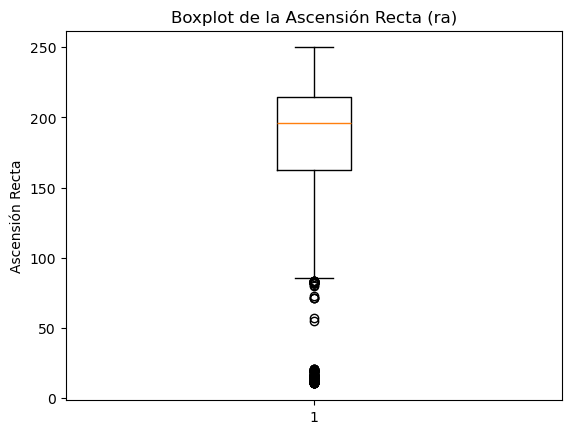

In [36]:
#Revisamos si se encuentra dentro del rango intercuartil, los valores que se encuentren por fuera de esto son outlayers [Q1−1.5×IQR,Q3+1.5×IQR]

Q1 = data_t['ra'].quantile(0.25)
Q3 = data_t['ra'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data_t[(data_t['ra'] < lower_bound) | (data_t['ra'] > upper_bound)]
# print(outliers['ra'])
outliers
plt.boxplot(data_t['ra'])
plt.title("Boxplot de la Ascensión Recta (ra)")
plt.ylabel("Ascensión Recta")
plt.show()

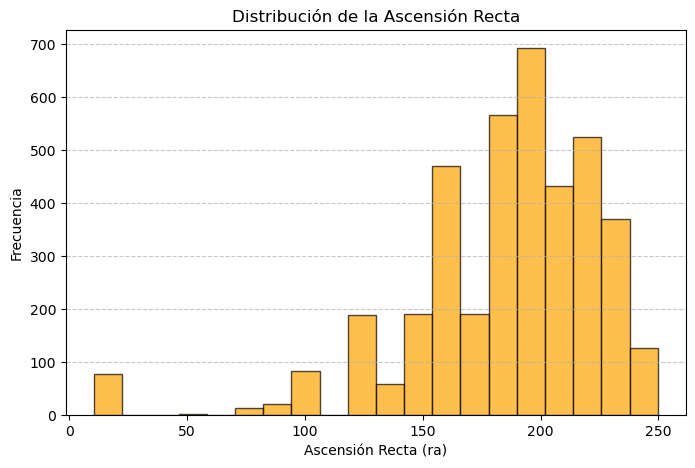

In [37]:
# Crear el histograma para visualizar la distribución de 'ra'
plt.figure(figsize=(8, 5))
plt.hist(data_t["ra"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (ra)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [38]:
for col in data_t.select_dtypes(include=['object']):
    print(f"Valores únicos en {col}:\n", data_t[col].unique())

Valores únicos en class:
 ['STAR' 'GALAXY' 'QSO' 'S' 'QUASAR' 'G']


## Columna dec
Describe: Ubicación del objeto en su componente de declinación de coordenada celeste.

In [39]:
data_t['u'].describe()


count    4000.000000
mean       18.609049
std         0.839431
min        13.551780
25%        18.170375
50%        18.843745
75%        19.261563
max        19.599750
Name: u, dtype: float64

In [40]:
#Revisamos si cuenta con valores negativos ya no que nos pide que sea mayor a 0
negativos = data_t[(data_t['u']<=0)]
print("Los valores negativos son estos ", negativos)

Los valores negativos son estos  Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


## Columna g

## 2. Análisis de calidad de los datos 
2.1 Completitud

In [41]:
# Cálculo de valores nulos por columna
((data_t.isnull().sum()/data_t.shape[0])).sort_values(ascending=False)


objid       0.0
ra          0.0
rowv        0.0
mjd         0.0
redshift    0.0
class       0.0
clean       0.0
score       0.0
field       0.0
camcol      0.0
run         0.0
z           0.0
i           0.0
r           0.0
g           0.0
u           0.0
dec         0.0
colv        0.0
dtype: float64

Al hacer un examen de completitud de los datos podemos ver que no hay datos nulos en ninguna columna del data frame

2.2 Unicidad

In [49]:
data_t.duplicated(keep = False).sum()
print(f"Filas duplicadas: {data_t.duplicated(keep=False).sum()}")

Filas duplicadas: 34


Se identificaron 34 filas duplicadas, ahora vamos a ver a detalle que es lo que está sucediendo

In [56]:
duplicados = data_t.loc[data_t.duplicated(keep=False)]
duplicados

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
88,1237648703513428079,206.374167,-0.781673,18.28101,17.18856,16.70175,16.33173,16.14626,752,2,420,0.904768,1,GALAXY,0.088136,51943,-0.002860,0.001156
109,1237648721231609897,182.015940,-0.116600,17.96686,16.91550,16.75447,16.68648,16.70880,756,3,442,0.876962,1,S,-0.000066,51615,-0.000639,0.000270
114,1237646382079606869,94.679499,0.842321,18.47695,16.94897,16.68126,16.59887,16.51747,211,6,359,0.806204,1,STAR,0.000207,52931,0.000372,-0.001017
299,1237648721756225804,154.036159,0.417930,19.50457,18.08980,17.29931,16.88134,16.56668,756,4,255,0.892071,1,GALAXY,0.096783,51883,-0.000413,-0.002812
629,1237648720687988788,166.623017,-0.546630,19.55528,17.73928,16.86703,16.44810,16.11761,756,2,339,0.879096,1,GALAXY,0.086721,51900,0.001004,-0.001857
642,1237648720715710772,229.932143,-0.607750,18.34448,17.39741,17.08713,16.86085,16.67511,756,2,762,0.846381,1,GALAXY,0.037010,51689,0.004917,-0.009145
718,1237648721789780467,230.664376,0.229439,19.48961,18.21590,17.50523,17.09294,16.87079,756,4,767,0.872553,1,GALAXY,0.112827,51673,0.008122,0.012494
719,1237648721788993889,228.864817,0.317359,18.88618,17.66549,17.09694,16.72708,16.56451,756,4,755,0.881142,1,GALAXY,0.082665,51689,-0.003803,-0.000683
856,1237648705679065271,247.896821,0.990909,16.74659,15.61752,15.43460,15.40196,15.40794,752,6,697,0.842783,1,STAR,0.000073,51671,0.002149,-0.000930
897,1237646382079672642,94.883887,0.990686,17.03847,15.47224,15.10297,14.97051,14.88297,211,6,360,0.806983,1,S,0.000012,52931,-0.001483,0.001376


Viendo a detalle los datos se puede ver que hay filas completamente duplicadas. Analizando el contexto de los datos y la forma en que se toman no tiene sentido que hayan filas completamente duplicadas, por lo cual consideramos eliminarlas.

2.3 Consistencia
Preguntar que otro tipo de prueba de consistencia de los datos.

In [59]:
errores_mjd = data_t[~data_t["mjd"].apply(lambda x: str(x).isdigit())]
print(errores_mjd)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


2.4 Validez